In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import scipy.sparse as sparse

%matplotlib inline

from implicit.als import AlternatingLeastSquares

In [6]:
bookmark = pd.read_table('bookmark/bookmarks.dat', sep="\t+", usecols=['id', 'md5', 'url', 'md5Principal', 'urlPrincipal'])

C:\Users\doktor\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [11]:
bookmark.rename(index=str, columns={"id": "bookmarkID"}, inplace=True)
bookmark.head()

,bookmarkID,md5,url,md5Principal,urlPrincipal
0,1,ab4954b633ddaf5b5bba6e9b71aa6b70,http://www.ifla.org/,7f431306c428457bc4e12b15634484f,www.ifla.org
1,2,2221e9cd106d269dd34682666f576fa3,http://archive.ifla.org/VII/s14/nd1/gcdp-e.pdf,1ef8cfcfe968101fa9b4e301847503d4,archive.ifla.org
2,7,c97c571dadaddbbb493126a0d4d01ba3,http://www.edselect.com/,792fd7eb20143386d0c4eb193c6124d,www.edselect.com
3,8,25bfe8dca0ef263ec9c341b9f16c38b5,http://www.collectionscanada.gc.ca/cool/index-...,6fce4f6391516f0732531d9cfacda5b7,www.collectionscanada.gc.ca
4,9,c97284629e17b8e2861afaacd59918bc,http://www.kidsreads.com/,5854ce8404857a45373eea01a3d98000,www.kidsreads.com


In [9]:
user_cont = pd.read_table('bookmark/user_contacts.dat')
user_cont.head()

,userID,contactID,date_day,date_month,date_year,date_hour,date_minute,date_second
0,8,28371,4,10,2010,2,14,19
1,8,40306,3,10,2010,12,33,9
2,8,85279,2,10,2010,3,10,48
3,8,91764,4,10,2010,22,43,47
4,8,97723,12,10,2010,3,28,33


In [10]:
user_tags = pd.read_table('bookmark/user_taggedbookmarks.dat')
user_tags.head()

,userID,bookmarkID,tagID,day,month,year,hour,minute,second
0,8,1,1,8,11,2010,23,29,22
1,8,2,1,8,11,2010,23,25,59
2,8,7,1,8,11,2010,18,55,1
3,8,7,6,8,11,2010,18,55,1
4,8,7,7,8,11,2010,18,55,1


In [12]:
joined = pd.merge(user_tags, bookmark, on='bookmarkID', how='left')

In [15]:
user_url = joined.groupby(['userID','urlPrincipal']).count().reset_index()
user_url.head()

,userID,urlPrincipal,bookmarkID,tagID,day,month,year,hour,minute,second,md5,url,md5Principal
0,8,addons.mozilla.org,1,1,1,1,1,1,1,1,1,1,1
1,8,archive.ifla.org,1,1,1,1,1,1,1,1,1,1,1
2,8,augusthouse.com,2,2,2,2,2,2,2,2,2,2,2
3,8,bctf.ca,1,1,1,1,1,1,1,1,1,1,1
4,8,blog.cathyjonelson.com,1,1,1,1,1,1,1,1,1,1,1


In [16]:
user_url.rename(index=str, columns={"bookmarkID": "urlCount"}, inplace=True)
user_url.drop(['tagID', 'day', 'month','year','hour','minute','second','md5','url','md5Principal'], axis=1, inplace=True)
user_url.head()

,userID,urlPrincipal,urlCount
0,8,addons.mozilla.org,1
1,8,archive.ifla.org,1
2,8,augusthouse.com,2
3,8,bctf.ca,1
4,8,blog.cathyjonelson.com,1


In [24]:
item_lookup = user_url[['urlPrincipal']].drop_duplicates()
url_id_name = {}

for index, row in item_lookup.iterrows():
    url_id_name[index] = row.urlPrincipal

In [34]:
urls = pd.DataFrame.from_dict(url_id_name, orient='index')

In [35]:
urls = urls.reset_index()
urls.rename(index=str, columns={"index": "urlID", 0:"urlPrincipal"}, inplace=True)
urls.head()

,urlID,urlPrincipal
0,0,addons.mozilla.org
1,1,archive.ifla.org
2,2,augusthouse.com
3,3,bctf.ca
4,4,blog.cathyjonelson.com


In [36]:
user_url = pd.merge(user_url, urls, on='urlPrincipal', how='left')

In [49]:
user_url.drop(['urlPrincipal'], axis=1, inplace=True)
user_url.head()

,userID,urlCount,urlID
0,8,1,0
1,8,1,1
2,8,2,2
3,8,1,3
4,8,1,4


In [80]:
users = list(np.sort(user_url.userID.astype(int).unique()))
urls  = list(np.sort(user_url.urlID.astype(int).unique()))
count = list(user_url.urlCount)

In [81]:
rows = user_url.userID.astype(int)
cols = user_url.urlID.astype(int)

In [63]:
len(urls)

38569

In [64]:
len(users)

1867

In [76]:
len(cols)

93149

In [78]:
len(rows)

93149

In [87]:
len(count)

93149

In [86]:
sparse.csr_matrix((len(urls), len(users)))

<38569x1867 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [85]:
data_sparse = sparse.csr_matrix((count, (cols,rows)), shape=(len(urls), len(users)))

ValueError: row index exceeds matrix dimensions

In [3]:
raw_data = raw_data.drop(raw_data.columns[1], axis=1)
raw_data.columns = ['user', 'artist', 'plays']

In [4]:
raw_data.head()

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
3,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
4,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691


In [5]:
data = raw_data.dropna()

In [18]:
data.loc[[1,2]]

,user,artist,plays
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717


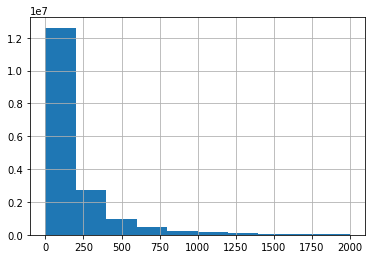

In [20]:
data.iloc[np.where(data.plays < 2000)].plays.hist()

In [21]:
data['user_id'] = data['user'].astype("category").cat.codes
data['artist_id'] = data['artist'].astype("category").cat.codes

/Users/aleksandrkondraskin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/aleksandrkondraskin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
data.head()

,user,artist,plays,user_id,artist_id
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,0,90933
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,0,185367
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,0,106704
3,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,0,155241
4,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691,0,220128


In [23]:
item_lookup = data[['artist_id', 'artist']].drop_duplicates()
item_lookup['artist_id'] = item_lookup.artist_id.astype(str)

In [24]:
item_lookup.head()

,artist_id,artist
0,90933,die Ärzte
1,185367,melissa etheridge
2,106704,elvenking
3,155241,juliette & the licks
4,220128,red hot chili peppers


In [25]:
artist_id_name = {}

for index, row in tqdm_notebook(item_lookup.iterrows()):
    artist_id_name[row.artist_id] = row.artist

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [26]:
data = data.drop(['user', 'artist'], axis=1)

In [27]:
data.head()

,plays,user_id,artist_id
0,1099,0,90933
1,897,0,185367
2,717,0,106704
3,706,0,155241
4,691,0,220128


In [28]:
data = data.loc[data.plays != 0]

In [29]:
data.head()

,plays,user_id,artist_id
0,1099,0,90933
1,897,0,185367
2,717,0,106704
3,706,0,155241
4,691,0,220128


In [30]:
users = list(np.sort(data.user_id.unique()))
artists = list(np.sort(data.artist_id.unique()))
plays = list(data.plays)

In [16]:
users[:5]

[0, 1, 2, 3, 4]

In [17]:
artists[:5]

[0, 1, 2, 3, 4]

In [18]:
plays[:5]

[1099, 897, 717, 706, 691]

In [40]:
len(users)

358868

In [41]:
len(artists)

292363

In [32]:
rows = data.user_id.astype(int)
cols = data.artist_id.astype(int)

In [33]:
data_sparse = sparse.csr_matrix((plays, (cols, rows)), shape=(len(artists), len(users)))

In [34]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

100%|██████████| 15.0/15 [02:50<00:00, 11.01s/it]


In [35]:
userid = 0

user_items = data_sparse.T.tocsr()
recommendations = model.recommend(userid, user_items)

In [36]:
recommendations

[(161833, 1.4250295),
 (255208, 1.4210296),
 (107103, 1.3288909),
 (116811, 1.2250009),
 (108566, 1.2193062),
 (12523, 1.2070069),
 (140813, 1.1961884),
 (205613, 1.1930802),
 (256750, 1.1905495),
 (249542, 1.1852744)]

In [39]:
for r in recommendations:
    print(artist_id_name[str(r[0])])

kittie
the dresden dolls
emilie autumn
flyleaf
epica
after forever
in this moment
otep
the gossip
tarja turunen


In [40]:
itemid = 107209
related = model.similar_items(itemid)

In [41]:
related

[(107209, 0.12407882),
 (157178, 0.11105041),
 (171169, 0.11082364),
 (261221, 0.1099599),
 (187011, 0.10985715),
 (127227, 0.10922149),
 (48904, 0.10792142),
 (218091, 0.10681016),
 (260378, 0.10674973),
 (155893, 0.10651716)]

In [42]:
for a in related:
    print(artist_id_name[str(a[0])])

eminem
kanye west
linkin park
the prodigy
michael jackson
gorillaz
black eyed peas
rage against the machine
the offspring
justin timberlake


In [37]:
artist_id_name['234786']

'sick on the bus'